In [69]:
## --- Load the pyGDM modules
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import propagators
from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import visu
from pyGDM2 import tools

## --- we will use numpy as well
import numpy as np
import matplotlib.pyplot as plt

In [70]:
material = materials.gold()

In [71]:
geometry = np.loadtxt('nanoparticle.xyz', usecols=(1,2,3), skiprows = 2)
geometry = structures.center_struct(geometry)
geometry[:,2] -= np.abs(np.min(geometry[:,2]))

step = tools.get_step_from_geometry(geometry)


structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 1032/1032 dipoles valid


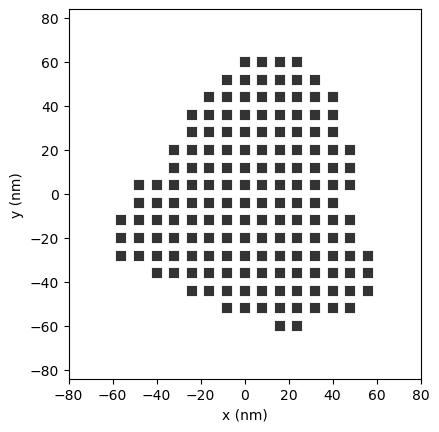

In [72]:
struct = structures.struct(step, geometry, material)

visu.structure(struct)


In [85]:
## --- we use again a plane wave
field_generator = fields.plane_wave
## --- this time however, we want to calculate a whole spectrum.
## --- we use numpy's *linspace* to get a list of linearly
## --- spaced wavelengths
wavelengths = np.linspace(400, 800, 20)

E_s=np.sqrt(0.5); E_p=np.sqrt(0.5); phase_Es=-np.pi/2   # POLARIZACAO ESQUERDA

kwargs = dict(E_s=E_s, E_p=E_p, phase_Es=phase_Es)
# kwargs = dict(theta = [0.0])
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## --- vacuum environment
n1 = n2 = 1.0
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)


In [86]:

## --- define the numerical experiment
sim = core.simulation(struct, efield, dyads)

In [87]:
sim.scatter()


timing for wl=400.00nm - setup: EE 40.5ms, inv.: 222.0ms, repropa.: 29.1ms (1 field configs), tot: 292.1ms
timing for wl=421.05nm - setup: EE 67.1ms, inv.: 204.9ms, repropa.: 30.5ms (1 field configs), tot: 302.9ms
timing for wl=442.11nm - setup: EE 70.6ms, inv.: 221.5ms, repropa.: 31.2ms (1 field configs), tot: 323.6ms
timing for wl=463.16nm - setup: EE 74.5ms, inv.: 206.0ms, repropa.: 30.9ms (1 field configs), tot: 311.7ms
timing for wl=484.21nm - setup: EE 76.7ms, inv.: 996.1ms, repropa.: 57.9ms (1 field configs), tot: 1130.9ms
timing for wl=505.26nm - setup: EE 80.2ms, inv.: 208.1ms, repropa.: 31.9ms (1 field configs), tot: 320.3ms
timing for wl=526.32nm - setup: EE 80.7ms, inv.: 357.2ms, repropa.: 33.2ms (1 field configs), tot: 471.4ms
timing for wl=547.37nm - setup: EE 77.2ms, inv.: 750.1ms, repropa.: 33.4ms (1 field configs), tot: 861.0ms
timing for wl=568.42nm - setup: EE 82.7ms, inv.: 209.3ms, repropa.: 34.2ms (1 field configs), tot: 326.6ms
timing for wl=589.47nm - setup: EE 7

1

In [88]:
ext, scat, abs = linear.extinct(sim, 0)


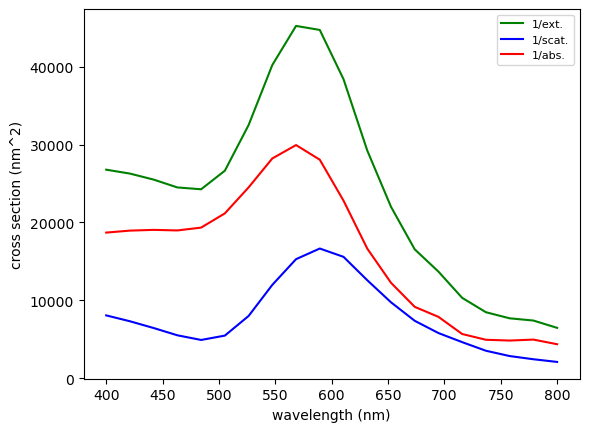

In [89]:
## get all simulated configurations, each corresponding to a spectrum
fieldKwargs1 = tools.get_possible_field_params_spectra(sim)

config_idx = 0
wl, spectrum = tools.calculate_spectrum(sim, fieldKwargs1[config_idx], linear.extinct)


## --- linear.extinct returns 3-tuples, "spectrum" therefore consists
## --- of an array of 3-tuples, corresponding to extinction,
## --- scattering and absorption.

plt.plot(wl, spectrum.T[0], 'g-', label='1/ext.')
plt.plot(wl, spectrum.T[1], 'b-', label='1/scat.')
plt.plot(wl, spectrum.T[2], 'r-', label='1/abs.')


plt.xlabel("wavelength (nm)")
plt.ylabel("cross section (nm^2)")
plt.legend(loc='best', fontsize=8)

plt.show()

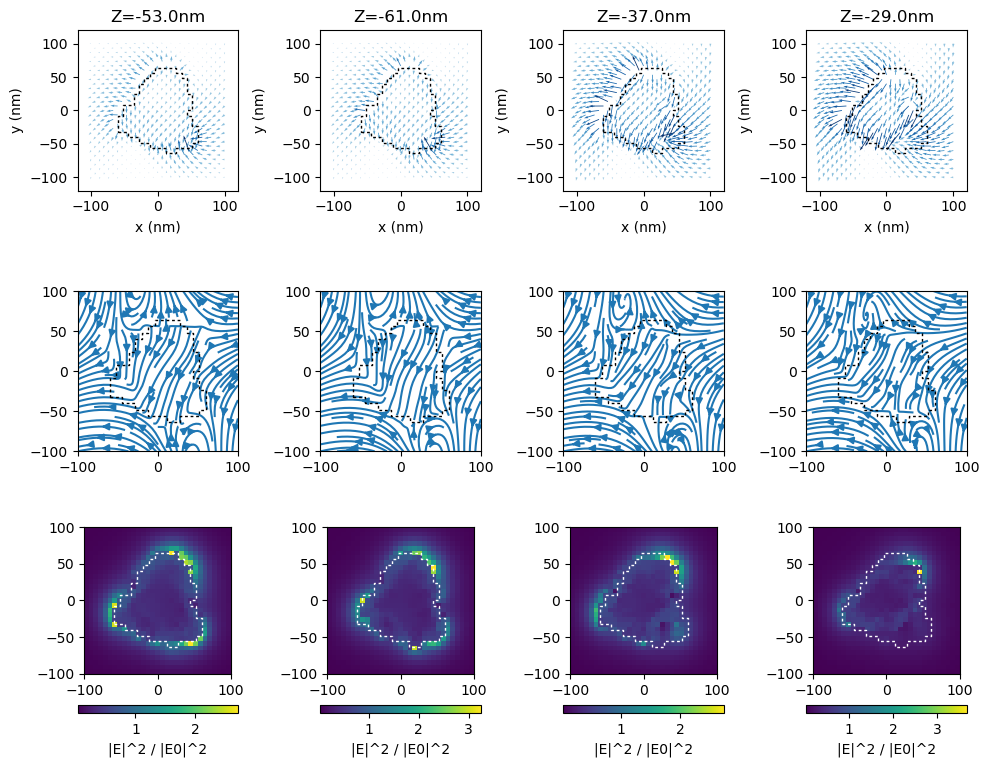

In [90]:
#==============================================================================
# Nearfield map below structure
#==============================================================================
minX = np.min(geometry.T[0])
maxX = np.max(geometry.T[0])
minY = np.min(geometry.T[1])
maxY = np.max(geometry.T[1])
minZ = np.min(geometry.T[2])
maxZ = np.max(geometry.T[2])
centerGeo = np.array([geometry.T[0].sum()/len(geometry.T[0]),
    geometry.T[1].sum()/len(geometry.T[1]),
    geometry.T[2].sum()/len(geometry.T[2])])


distances = [centerGeo[2]+0*step, centerGeo[2]-1*step, centerGeo[2]+2*step, centerGeo[2]+3*step] 

Es = []
Bs = []
Etot = []
Btot = []
for Z0 in distances:
    r_probe = tools.generate_NF_map_XY(-100,100,31, -100,100,31, Z0=Z0)

    ## --- linear.nearfield takes either a whole "map" or only a
    ## --- 3D coordinate as input. Here we want the field on a map.
    _Es, _Etot, _Bs, _Btot = linear.nearfield(sim, field_index=0, r_probe=r_probe)
    Es.append(_Es)
    Etot.append(_Etot)
    Bs.append(_Bs)
    Btot.append(_Btot)

## --- limit the number of ticks on the axes (for the colorbar!)
from matplotlib.ticker import MaxNLocator
MaxNLocator.default_params['nbins'] = 4

## the plot
plt.figure(figsize=(10, 8))

for i, _Es in enumerate(Es):
    ## --- field vectors
    plt.subplot(3,len(Es),1+i, aspect='equal')
    plt.title("Z={}nm".format(round(distances[i],0)))
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='k', show=0)
    visu.vectorfield(_Es, show=0, EACHN=2)

    ## --- field isolines
    plt.subplot(3,len(Es),1+1*len(Es)+i, aspect='equal')
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='k', show=0)
    visu.vectorfield_fieldlines(_Es, show=0)

    ## --- field intensity
    plt.subplot(3,len(Es),1+2*len(Es)+i, aspect='equal')
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='w', show=0)
    im = visu.vectorfield_color(_Es, show=0)
    plt.colorbar(im, orientation='horizontal', label="|E|^2 / |E0|^2")

plt.tight_layout()
plt.show()